IMPORTS

In [19]:
import os
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

TensorFlow Version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


PATHS AND CONFIGURATION

In [20]:
# Dataset paths
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

# PSO model paths
pso_model_path = '/kaggle/input/pso-outputs/pso_optimized_model.keras'
pso_results_path = '/kaggle/input/pso-outputs/pso_results_summary.json'
pso_history_path = '/kaggle/input/pso-outputs/pso_optimization_history.json'

# Output directory
output_dir = '/kaggle/working/gradcam_optimization'
os.makedirs(output_dir, exist_ok=True)

# PSO Configuration for Grad-CAM
N_PARTICLES = 8
N_ITERATIONS = 10

print(f"PSO Particles: {N_PARTICLES}")
print(f"PSO Iterations: {N_ITERATIONS}")
print(f"Output directory: {output_dir}")

# Verify files exist
print("\nChecking data sources")
print(f"  Dataset train: {os.path.exists(train_dir)}")
print(f"  Dataset test: {os.path.exists(test_dir)}")
print(f"  PSO model: {os.path.exists(pso_model_path)}")
print(f"  PSO results: {os.path.exists(pso_results_path)}")
print(f"  PSO history: {os.path.exists(pso_history_path)}")

PSO Particles: 8
PSO Iterations: 10
Output directory: /kaggle/working/gradcam_optimization

Checking data sources
  Dataset train: True
  Dataset test: True
  PSO model: True
  PSO results: True
  PSO history: True


 LOAD PSO MODEL AND RESULTS

In [21]:
pso_model = load_model(pso_model_path)
# BUILD THE MODEL
dummy_input = tf.zeros((1, 128, 128, 3))
try:
    _ = pso_model(dummy_input, training=False)
    print(" Model built successfully")
except Exception as e:
    print(f"Note: {e}")
    print("Will handle model building in Grad-CAM function")

with open(pso_results_path, 'r') as f:
    pso_results = json.load(f)

print(f"\n PSO Model Performance:")
print(f"  Test Accuracy: {pso_results['final_model']['test_accuracy']*100:.2f}%")
print(f"  Val Accuracy: {pso_results['final_model']['val_accuracy']*100:.2f}%")
print(f"  Best Epoch: {pso_results['final_model']['best_epoch']}")

pso_model.summary()

 Model built successfully

 PSO Model Performance:
  Test Accuracy: 74.60%
  Val Accuracy: 75.44%
  Best Epoch: 14


Model: "BrainTumorCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 39)   │         1,092 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128, 128, 39)   │           156 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 39)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64, 64, 39)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        22,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 184)    │       106,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 184)    │           736 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 184)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16, 16, 184)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 47104)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 420)            │    19,784,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 420)            │         1,680 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 420)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 210)            │        88,410 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 210)            │           840 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 210)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           844 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,016,764 (228.95 MB)

 Trainable params: 20,004,976 (76.31 MB)

 Non-trainable params: 1,834 (7.16 KB)

 Optimizer params: 40,009,954 (152.63 MB)

LOAD TEST DATA

In [22]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

class_names = list(test_generator.class_indices.keys())
n_classes = len(class_names)

print(f"\n Test data loaded")
print(f"  Classes: {class_names}")
print(f"  Test samples: {test_generator.samples}")

Found 1311 images belonging to 4 classes.

 Test data loaded
  Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
  Test samples: 1311


GRAD-CAM IMPLEMENTATION

In [23]:
def find_last_conv_layer(model):
    """Find the last convolutional layer in the model"""
    for layer in reversed(model.layers):
        if 'conv' in layer.name.lower():
            return layer.name
    return None

last_conv_layer_name = find_last_conv_layer(pso_model)
print(f" Last Convolutional Layer: {last_conv_layer_name}\n")

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Generate Grad-CAM heatmap
    
    Args:
        img_array: Input image array (batch_size, height, width, channels)
        model: Keras model
        last_conv_layer_name: Name of last conv layer
        pred_index: Class index to explain (None = top prediction)
    
    Returns:
        heatmap: Grad-CAM heatmap (height, width)
    """
    # Create a model that outputs both conv layer and predictions
    last_conv_layer = model.get_layer(last_conv_layer_name)
    
    # Use GradientTape to compute gradients
    with tf.GradientTape() as tape:
        # Forward pass
        last_conv_output = None
        x = img_array
        
        for layer in model.layers:
            if layer.name == last_conv_layer_name:
                # Watch this layer's output
                x = layer(x)
                tape.watch(x)
                last_conv_output = x
            else:
                x = layer(x)
        
        predictions = x
        
        # Get the class channel
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    
    # Gradient of class output with respect to feature map
    grads = tape.gradient(class_channel, last_conv_output)
    
    # Handle None gradients
    if grads is None:
        print("Warning: Gradients are None")
        return np.zeros((32, 32))
    
    # Global average pooling of gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Weight feature maps by gradient importance
    conv_output_value = last_conv_output[0]
    heatmap = conv_output_value @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # Normalize heatmap
    heatmap = tf.maximum(heatmap, 0)
    max_val = tf.math.reduce_max(heatmap)
    if max_val > 0:
        heatmap = heatmap / max_val
    
    return heatmap.numpy()

def apply_gradcam_overlay(img, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    """
    Apply Grad-CAM heatmap overlay on image
    
    Args:
        img: Original image (H, W, C) in [0, 1] or [0, 255]
        heatmap: Grad-CAM heatmap (h, w)
        alpha: Overlay transparency (0-1)
        colormap: OpenCV colormap
    
    Returns:
        overlay: Image with heatmap overlay
    """
    # Ensure image is uint8
    if img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)
    else:
        img = img.astype(np.uint8)
    
    # Resize heatmap to image size
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # Convert heatmap to RGB
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), colormap)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    
    # Blend with original image
    overlay = cv2.addWeighted(img, 1-alpha, heatmap_colored, alpha, 0)
    
    return overlay

 Last Convolutional Layer: conv2d_5



GRAD-CAM QUALITY METRICS

In [24]:
def calculate_gradcam_metrics(heatmap, img_array, model, true_class_idx):
    # Check for invalid heatmap
    if heatmap is None or heatmap.size == 0:
        return {
            'quality_score': 0.0,
            'focus': 0.0,
            'coverage': 0.0,
            'coverage_score': 0.0,
            'coherence': 0.0,
            'intensity': 0.0,
            'peak': 0.0
        }
    
    # 1. Focus (entropy-based)
    heatmap_flat = heatmap.flatten()
    heatmap_sum = heatmap_flat.sum()
    
    if heatmap_sum < 1e-10:
        return {
            'quality_score': 0.0,
            'focus': 0.0,
            'coverage': 0.0,
            'coverage_score': 0.0,
            'coherence': 0.0,
            'intensity': 0.0,
            'peak': 0.0
        }
    
    heatmap_norm = heatmap_flat / heatmap_sum
    # Avoid log(0) by adding small epsilon
    heatmap_norm = np.clip(heatmap_norm, 1e-10, 1.0)
    entropy = -np.sum(heatmap_norm * np.log(heatmap_norm))
    max_entropy = np.log(heatmap.size)
    focus_score = 1.0 - (entropy / max_entropy)  # Higher = more focused
    
    # 2. Coverage (percentage of image with high activation)
    threshold = 0.5
    coverage = np.sum(heatmap > threshold) / heatmap.size
    # Optimal coverage around 0.3-0.4
    coverage_score = 1.0 - abs(coverage - 0.35) * 2
    coverage_score = max(0, coverage_score)
    
    # 3. Coherence (smoothness via gradient)
    if heatmap.shape[0] > 1 and heatmap.shape[1] > 1:
        grad_y = np.abs(np.diff(heatmap, axis=0))
        grad_x = np.abs(np.diff(heatmap, axis=1))
        coherence = 1.0 / (1.0 + np.mean(grad_y) + np.mean(grad_x))
    else:
        coherence = 0.0
    
    # 4. Intensity (average activation strength)
    high_activation_mask = heatmap > 0.1
    if np.sum(high_activation_mask) > 0:
        intensity = np.mean(heatmap[high_activation_mask])
    else:
        intensity = 0.0
    
    # 5. Peak Strength (max activation value)
    peak = np.max(heatmap)
    
    # Combined quality score
    quality_score = (
        0.30 * focus_score +
        0.25 * coverage_score +
        0.20 * coherence +
        0.15 * intensity +
        0.10 * peak
    )
    
    return {
        'quality_score': quality_score,
        'focus': focus_score,
        'coverage': coverage,
        'coverage_score': coverage_score,
        'coherence': coherence,
        'intensity': intensity,
        'peak': peak
    }

GRAD-CAM PARAMETER BOUNDS

In [25]:
GRADCAM_BOUNDS = {
    'alpha': (0.2, 0.8, 'continuous'),           # Overlay transparency
    'colormap': (0, 11, 'discrete'),             # OpenCV colormap ID
    'heatmap_threshold': (0.3, 0.7, 'continuous'), # Threshold for binarization
    'smoothing_sigma': (0.0, 3.0, 'continuous')  # Gaussian blur sigma
}

# OpenCV colormap options
COLORMAPS = {
    0: cv2.COLORMAP_JET,
    1: cv2.COLORMAP_HOT,
    2: cv2.COLORMAP_RAINBOW,
    3: cv2.COLORMAP_OCEAN,
    4: cv2.COLORMAP_SUMMER,
    5: cv2.COLORMAP_SPRING,
    6: cv2.COLORMAP_COOL,
    7: cv2.COLORMAP_HSV,
    8: cv2.COLORMAP_PINK,
    9: cv2.COLORMAP_BONE,
    10: cv2.COLORMAP_AUTUMN,
    11: cv2.COLORMAP_VIRIDIS
}
print("GRAD-CAM PARAMETER SEARCH SPACE")
for param, (low, high, ptype) in GRADCAM_BOUNDS.items():
    print(f"  {param:20s}: [{low:.2f}, {high:.2f}] ({ptype})")

GRAD-CAM PARAMETER SEARCH SPACE
  alpha               : [0.20, 0.80] (continuous)
  colormap            : [0.00, 11.00] (discrete)
  heatmap_threshold   : [0.30, 0.70] (continuous)
  smoothing_sigma     : [0.00, 3.00] (continuous)


PSO PARTICLE CLASS

In [26]:
class Particle:
    """PSO Particle for Grad-CAM parameter optimization"""
    
    def __init__(self, bounds):
        self.bounds = bounds
        self.position = {}
        self.velocity = {}
        self.best_position = {}
        self.best_score = -np.inf
        
        # Initialize random position
        for param, (low, high, param_type) in bounds.items():
            if param_type == 'continuous':
                self.position[param] = np.random.uniform(low, high)
                self.velocity[param] = np.random.uniform(-0.1, 0.1) * (high - low)
            else:  # discrete
                self.position[param] = float(np.random.randint(low, high + 1))
                self.velocity[param] = np.random.uniform(-0.5, 0.5)
        
        self.best_position = self.position.copy()
    
    def update_velocity(self, global_best_position, w=0.7, c1=1.5, c2=1.5):
        """Update particle velocity"""
        for param in self.position.keys():
            r1 = np.random.random()
            r2 = np.random.random()
            
            cognitive = c1 * r1 * (self.best_position[param] - self.position[param])
            social = c2 * r2 * (global_best_position[param] - self.position[param])
            
            self.velocity[param] = w * self.velocity[param] + cognitive + social
    
    def update_position(self):
        """Update particle position"""
        for param, (low, high, param_type) in self.bounds.items():
            self.position[param] += self.velocity[param]
            self.position[param] = np.clip(self.position[param], low, high)
    
    def get_discrete_position(self):
        """Convert position to discrete values where needed"""
        discrete = {}
        for param, value in self.position.items():
            _, _, param_type = self.bounds[param]
            if param_type == 'discrete':
                discrete[param] = int(round(value))
            else:
                discrete[param] = float(value)
        return discrete

GRAD-CAM EVALUATION FUNCTION

In [27]:
def evaluate_gradcam_params(params, model, test_samples, last_conv_layer):
    alpha = params['alpha']
    colormap_id = params['colormap']
    threshold = params['heatmap_threshold']
    sigma = params['smoothing_sigma']
    
    colormap = COLORMAPS.get(colormap_id, cv2.COLORMAP_JET)
    
    quality_scores = []
    
    for img_path, true_class_idx in test_samples:
        try:
            # Load image
            img = load_img(img_path, target_size=(128, 128))
            img_array = img_to_array(img) / 255.0
            img_array_expanded = np.expand_dims(img_array, axis=0)
            
            # Generate Grad-CAM
            heatmap = make_gradcam_heatmap(
                img_array_expanded, 
                model, 
                last_conv_layer
            )
            
            # Apply smoothing if specified
            if sigma > 0:
                heatmap = cv2.GaussianBlur(heatmap, (5, 5), sigma)
                heatmap = heatmap / (heatmap.max() + 1e-10)  # Renormalize
            
            # Calculate metrics
            metrics = calculate_gradcam_metrics(
                heatmap, 
                img_array_expanded, 
                model, 
                true_class_idx
            )
            
            quality_scores.append(metrics['quality_score'])
            
        except Exception as e:
            print(f"  Warning: Error processing sample - {e}")
            quality_scores.append(0.0)
    
    return np.mean(quality_scores) if quality_scores else 0.0

 PREPARE TEST SAMPLES

In [28]:
# Select representative samples from each class
test_samples = []
samples_per_class = 10

for class_name in class_names:
    class_dir = os.path.join(test_dir, class_name)
    class_idx = test_generator.class_indices[class_name]
    
    image_files = [f for f in os.listdir(class_dir) 
                  if f.endswith(('.jpg', '.jpeg', '.png'))][:samples_per_class]
    
    for img_file in image_files:
        img_path = os.path.join(class_dir, img_file)
        test_samples.append((img_path, class_idx))

print(f"\n Selected {len(test_samples)} test samples")
print(f"  Samples per class: {samples_per_class}")
print(f"  Total classes: {n_classes}\n")



 Selected 40 test samples
  Samples per class: 10
  Total classes: 4



PSO OPTIMIZER

In [29]:
class PSO_GradCAM_Optimizer:
    """PSO for Grad-CAM parameter optimization"""
    
    def __init__(self, bounds, n_particles=10, n_iterations=20, w=0.7, c1=1.5, c2=1.5):
        self.bounds = bounds
        self.n_particles = n_particles
        self.n_iterations = n_iterations
        self.w = w
        self.c1 = c1
        self.c2 = c2
        
        # Initialize swarm
        self.swarm = [Particle(bounds) for _ in range(n_particles)]
        
        # Global best
        self.global_best_position = None
        self.global_best_score = -np.inf
        
        # History
        self.history = {
            'iteration': [],
            'best_score': [],
            'mean_score': [],
            'std_score': []
        }
    
    def optimize(self, model, test_samples, last_conv_layer):
        """Run PSO optimization"""
        print("STARTING PSO OPTIMIZATION FOR GRAD-CAM")
        print(f"Particles: {self.n_particles}")
        print(f"Iterations: {self.n_iterations}")
        print(f"Test samples: {len(test_samples)}\n")
        
        start_time = time.time()
        
        for iteration in range(self.n_iterations):
            print(f"ITERATION {iteration + 1}/{self.n_iterations}")
       
            
            iteration_scores = []
            
            # Evaluate all particles
            for i, particle in enumerate(self.swarm):
                params = particle.get_discrete_position()
                
                print(f"\n[Particle {i+1}/{self.n_particles}]")
                print(f"  Params: α={params['alpha']:.3f}, cmap={params['colormap']}, "
                      f"thresh={params['heatmap_threshold']:.3f}, σ={params['smoothing_sigma']:.2f}")
                
                score = evaluate_gradcam_params(
                    params, 
                    model, 
                    test_samples, 
                    last_conv_layer
                )
                
                # Handle NaN scores
                if np.isnan(score) or np.isinf(score):
                    score = 0.0
                
                print(f"  Score: {score:.4f}")
                iteration_scores.append(score)
                
                # Update particle best
                if score > particle.best_score:
                    particle.best_score = score
                    particle.best_position = particle.position.copy()
                
                # Update global best
                if score > self.global_best_score:
                    self.global_best_score = score
                    self.global_best_position = particle.position.copy()
                    print(f" NEW GLOBAL BEST: {self.global_best_score:.4f}")
            
            # Only update velocities if we have a valid global best
            if self.global_best_position is not None:
                for particle in self.swarm:
                    particle.update_velocity(self.global_best_position, self.w, self.c1, self.c2)
                    particle.update_position()
            
            # Record history
            self.history['iteration'].append(iteration + 1)
            self.history['best_score'].append(self.global_best_score)
            self.history['mean_score'].append(np.mean(iteration_scores))
            self.history['std_score'].append(np.std(iteration_scores))
            
            print(f"Iteration {iteration + 1} Summary:")
            print(f"  Best Score:  {self.global_best_score:.4f}")
            print(f"  Mean Score:  {np.mean(iteration_scores):.4f}")
            print(f"  Std Score:   {np.std(iteration_scores):.4f}")
        
        elapsed = (time.time() - start_time) / 60
        print(f"Time: {elapsed:.2f} minutes")
        print(f"Best score: {self.global_best_score:.4f}")
        
        # Get discrete best parameters - handle case where no valid solution found
        if self.global_best_position is None:
            print("\nWARNING: No valid solution found. Using default parameters.")
            best_params_discrete = {
                'alpha': 0.4,
                'colormap': 0,
                'heatmap_threshold': 0.5,
                'smoothing_sigma': 0.5
            }
        else:
            best_params_discrete = {}
            for param, value in self.global_best_position.items():
                _, _, param_type = self.bounds[param]
                if param_type == 'discrete':
                    best_params_discrete[param] = int(round(value))
                else:
                    best_params_discrete[param] = float(value)

        print(f"\n{'='*60}")
        print("BEST GRAD-CAM PARAMETERS")
        print(f"{'='*60}")
        for param, value in best_params_discrete.items():
            print(f"  {param:20s}: {value}")
        print(f"{'='*60}\n")
        
        return best_params_discrete, self.global_best_score
    
    def plot_convergence(self, save_path=None):
        """Plot PSO convergence"""
        fig, ax = plt.subplots(figsize=(12, 6))
        
        ax.plot(self.history['iteration'], self.history['best_score'],
               'b-o', linewidth=2, markersize=6, label='Best Score')
        ax.plot(self.history['iteration'], self.history['mean_score'],
               'r--s', linewidth=2, markersize=5, label='Mean Score')
        ax.fill_between(self.history['iteration'],
                       np.array(self.history['mean_score']) - np.array(self.history['std_score']),
                       np.array(self.history['mean_score']) + np.array(self.history['std_score']),
                       alpha=0.2, color='red')
        
        ax.set_xlabel('Iteration', fontsize=12, fontweight='bold')
        ax.set_ylabel('Grad-CAM Quality Score', fontsize=12, fontweight='bold')
        ax.set_title('PSO Convergence - Grad-CAM Parameter Optimization', 
                    fontsize=14, fontweight='bold')
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()

RUN PSO OPTIMIZATION

STARTING PSO OPTIMIZATION FOR GRAD-CAM
Particles: 8
Iterations: 10
Test samples: 40

ITERATION 1/10

[Particle 1/8]
  Params: α=0.425, cmap=10, thresh=0.539, σ=0.30
  Score: 0.4629
 NEW GLOBAL BEST: 0.4629

[Particle 2/8]
  Params: α=0.400, cmap=2, thresh=0.688, σ=0.64
  Score: 0.4599

[Particle 3/8]
  Params: α=0.310, cmap=5, thresh=0.309, σ=1.20
  Score: 0.4688
 NEW GLOBAL BEST: 0.4688

[Particle 4/8]
  Params: α=0.784, cmap=2, thresh=0.693, σ=2.58
  Score: 0.4830
 NEW GLOBAL BEST: 0.4830

[Particle 5/8]
  Params: α=0.470, cmap=8, thresh=0.623, σ=0.29
  Score: 0.4627

[Particle 6/8]
  Params: α=0.464, cmap=7, thresh=0.664, σ=1.99
  Score: 0.4806

[Particle 7/8]
  Params: α=0.512, cmap=5, thresh=0.637, σ=1.19
  Score: 0.4685

[Particle 8/8]
  Params: α=0.636, cmap=6, thresh=0.684, σ=2.24
  Score: 0.4816
Iteration 1 Summary:
  Best Score:  0.4830
  Mean Score:  0.4710
  Std Score:   0.0088
ITERATION 2/10

[Particle 1/8]
  Params: α=0.800, cmap=7, thresh=0.574, σ=1.73
  Score: 0.4779

[

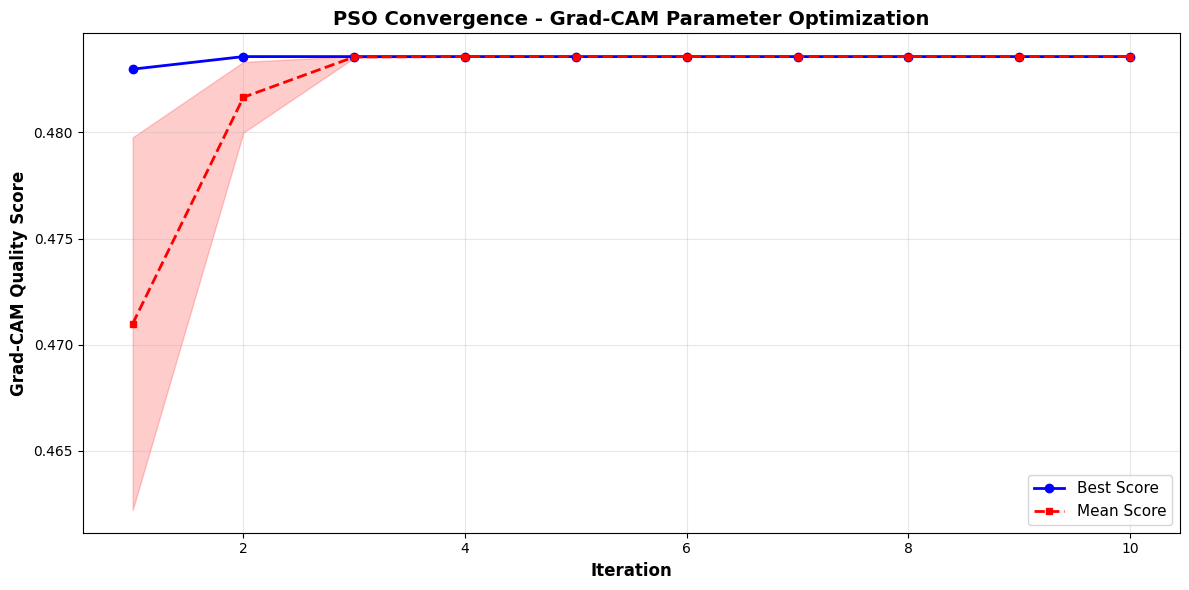

In [30]:
optimizer = PSO_GradCAM_Optimizer(
    bounds=GRADCAM_BOUNDS,
    n_particles=N_PARTICLES,
    n_iterations=N_ITERATIONS,
    w=0.7,
    c1=1.5,
    c2=1.5
)

best_gradcam_params, best_gradcam_score = optimizer.optimize(
    pso_model,
    test_samples,
    last_conv_layer_name
)

# Plot convergence
optimizer.plot_convergence(save_path=os.path.join(output_dir, 'gradcam_pso_convergence.png'))

SAVE RESULTS

In [31]:
# Save best parameters
with open(os.path.join(output_dir, 'best_gradcam_parameters.json'), 'w') as f:
    json.dump(best_gradcam_params, f, indent=2)

# Save optimization history
with open(os.path.join(output_dir, 'gradcam_pso_history.json'), 'w') as f:
    json.dump(optimizer.history, f, indent=2)

# Save summary
summary = {
    'optimization': {
        'algorithm': 'Particle Swarm Optimization',
        'n_particles': N_PARTICLES,
        'n_iterations': N_ITERATIONS,
        'best_score': float(best_gradcam_score),
        'best_parameters': best_gradcam_params
    },
    'model_performance': {
        'test_accuracy': pso_results['final_model']['test_accuracy'],
        'val_accuracy': pso_results['final_model']['val_accuracy']
    }
}

with open(os.path.join(output_dir, 'gradcam_optimization_summary.json'), 'w') as f:
    json.dump(summary, f, indent=2)

print(f" Saved: best_gradcam_parameters.json")
print(f" Saved: gradcam_pso_history.json")
print(f" Saved: gradcam_optimization_summary.json")
print(f" Saved: gradcam_pso_convergence.png")

 Saved: best_gradcam_parameters.json
 Saved: gradcam_pso_history.json
 Saved: gradcam_optimization_summary.json
 Saved: gradcam_pso_convergence.png


DEMONSTRATE OPTIMIZED GRAD-CAM

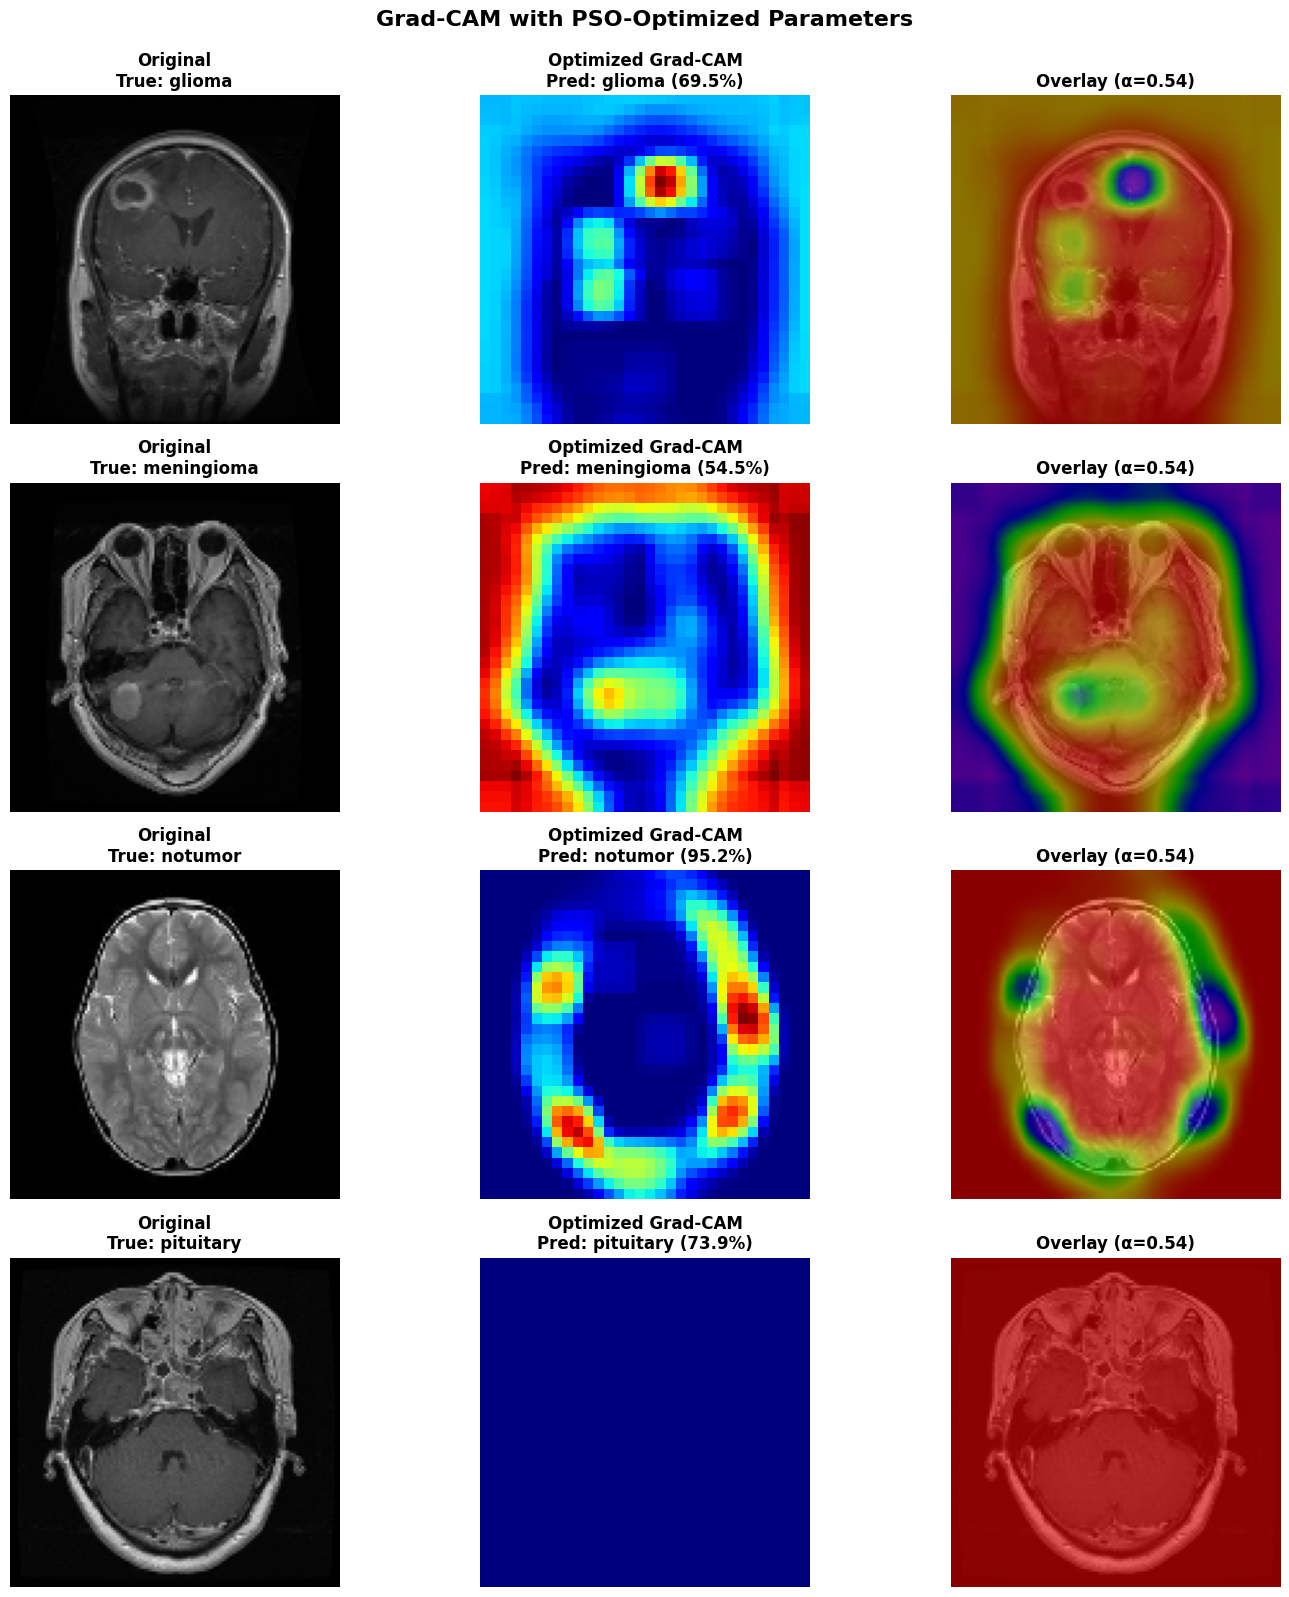

In [32]:
# Select one sample from each class
demo_samples = []
for class_name in class_names:
    class_dir = os.path.join(test_dir, class_name)
    class_idx = test_generator.class_indices[class_name]
    img_file = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png'))][0]
    demo_samples.append((os.path.join(class_dir, img_file), class_name, class_idx))

# Visualize with optimized parameters
alpha_opt = best_gradcam_params['alpha']
colormap_opt = COLORMAPS[best_gradcam_params['colormap']]
sigma_opt = best_gradcam_params['smoothing_sigma']

fig, axes = plt.subplots(n_classes, 3, figsize=(15, 4*n_classes))

for idx, (img_path, class_name, class_idx) in enumerate(demo_samples):
    # Load image
    img = load_img(img_path, target_size=(128, 128))
    img_array = img_to_array(img) / 255.0
    img_array_expanded = np.expand_dims(img_array, axis=0)
    
    # Predict
    pred = pso_model.predict(img_array_expanded, verbose=0)[0]
    pred_class = class_names[np.argmax(pred)]
    confidence = np.max(pred) * 100
    
    # Generate Grad-CAM
    heatmap = make_gradcam_heatmap(img_array_expanded, pso_model, last_conv_layer_name)
    
    # Apply smoothing
    if sigma_opt > 0:
        heatmap = cv2.GaussianBlur(heatmap, (5, 5), sigma_opt)
        heatmap = heatmap / (heatmap.max() + 1e-10)
    
    # Create overlay
    img_np = (img_array * 255).astype(np.uint8)
    overlay = apply_gradcam_overlay(img_np, heatmap, alpha_opt, colormap_opt)
    
    # Plot
    axes[idx, 0].imshow(img)
    axes[idx, 0].set_title(f"Original\nTrue: {class_name}", fontweight='bold')
    axes[idx, 0].axis('off')
    
    axes[idx, 1].imshow(heatmap, cmap='jet')
    axes[idx, 1].set_title(f"Optimized Grad-CAM\nPred: {pred_class} ({confidence:.1f}%)", 
                          fontweight='bold')
    axes[idx, 1].axis('off')
    
    axes[idx, 2].imshow(overlay)
    axes[idx, 2].set_title(f"Overlay (α={alpha_opt:.2f})", fontweight='bold')
    axes[idx, 2].axis('off')

plt.suptitle('Grad-CAM with PSO-Optimized Parameters', 
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'optimized_gradcam_demo.png'), dpi=300, bbox_inches='tight')
plt.show()

EVALUATE MODEL ACCURACY

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



 Test Set Performance:
  Loss: 1.3694
  Accuracy: 74.60%

Generating predictions for detailed analysis

 Per-Class Accuracy:
  glioma         : Accuracy= 52.67%  Precision= 98.75%  F1= 68.70%  (n=300)
  meningioma     : Accuracy= 69.61%  Precision= 49.31%  F1= 57.72%  (n=306)
  notumor        : Accuracy= 94.32%  Precision= 83.04%  F1= 88.32%  (n=405)
  pituitary      : Accuracy= 75.00%  Precision= 86.87%  F1= 80.50%  (n=300)

 Overall Metrics:
  Macro Avg Precision: 79.49%
  Macro Avg Recall:    72.90%
  Macro Avg F1-Score:  73.81%
  Weighted Avg F1:     74.90%


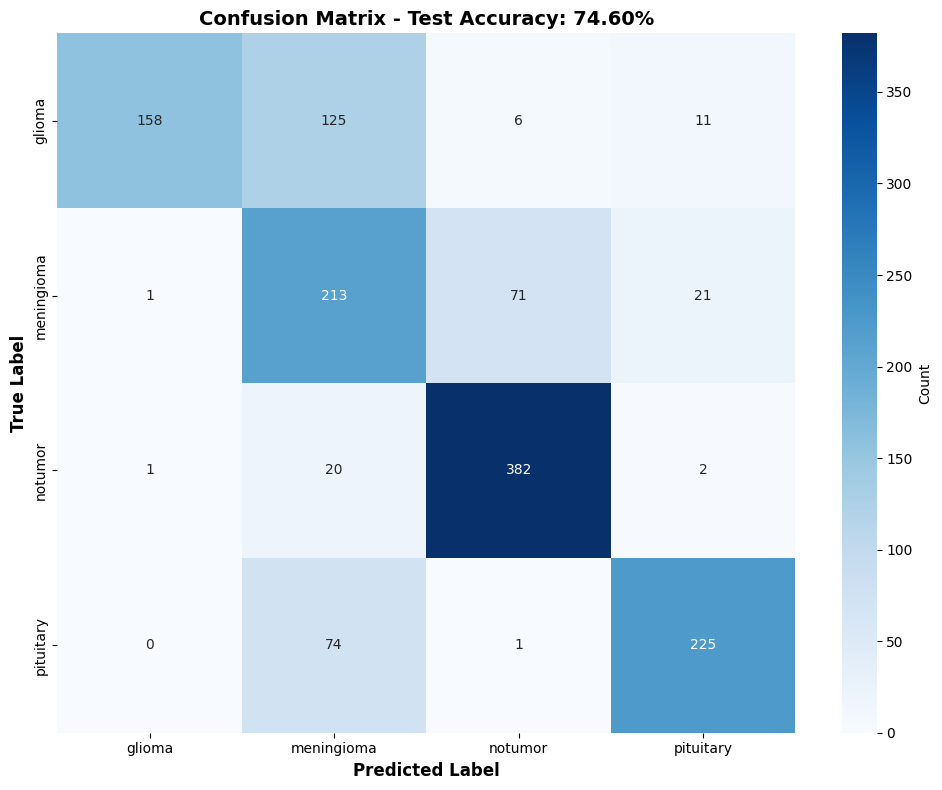

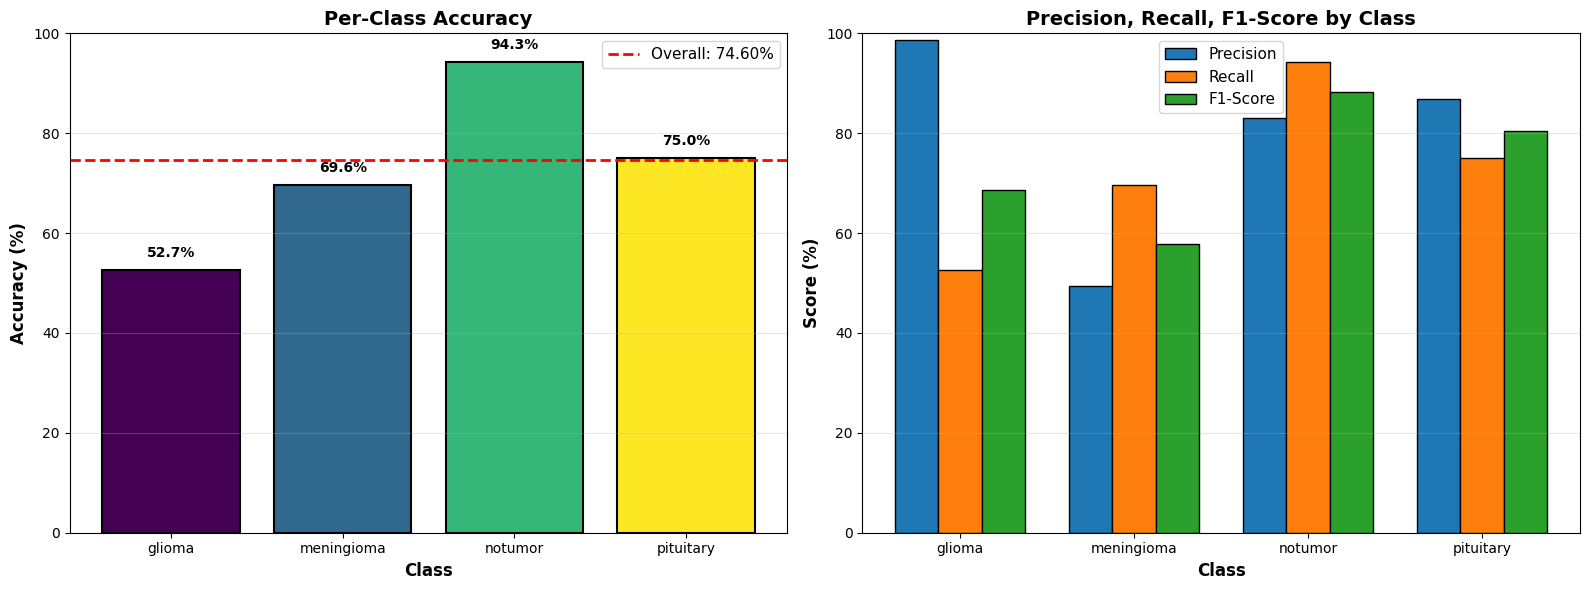

In [33]:
# Evaluate on test set
test_generator.reset()
test_loss, test_accuracy = pso_model.evaluate(test_generator, verbose=0)

print(f"\n Test Set Performance:")
print(f"  Loss: {test_loss:.4f}")
print(f"  Accuracy: {test_accuracy*100:.2f}%")

# Get predictions for confusion matrix
print("\nGenerating predictions for detailed analysis")
test_generator.reset()
y_pred_probs = pso_model.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Calculate per-class accuracy
print(f"\n Per-Class Accuracy:")
from sklearn.metrics import classification_report, confusion_matrix

class_report = classification_report(y_true, y_pred, 
                                     target_names=class_names, 
                                     digits=4,
                                     output_dict=True)

for class_name in class_names:
    acc = class_report[class_name]['recall'] * 100
    precision = class_report[class_name]['precision'] * 100
    f1 = class_report[class_name]['f1-score'] * 100
    support = int(class_report[class_name]['support'])
    print(f"  {class_name:15s}: Accuracy={acc:6.2f}%  Precision={precision:6.2f}%  F1={f1:6.2f}%  (n={support})")

# Overall metrics
print(f"\n Overall Metrics:")
print(f"  Macro Avg Precision: {class_report['macro avg']['precision']*100:.2f}%")
print(f"  Macro Avg Recall:    {class_report['macro avg']['recall']*100:.2f}%")
print(f"  Macro Avg F1-Score:  {class_report['macro avg']['f1-score']*100:.2f}%")
print(f"  Weighted Avg F1:     {class_report['weighted avg']['f1-score']*100:.2f}%")

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'}, ax=ax)
ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_title(f'Confusion Matrix - Test Accuracy: {test_accuracy*100:.2f}%', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

# Plot Per-Class Performance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy per class
class_accuracies = [class_report[cn]['recall']*100 for cn in class_names]
colors = plt.cm.viridis(np.linspace(0, 1, len(class_names)))

axes[0].bar(class_names, class_accuracies, color=colors, edgecolor='black', linewidth=1.5)
axes[0].axhline(y=test_accuracy*100, color='red', linestyle='--', linewidth=2, label=f'Overall: {test_accuracy*100:.2f}%')
axes[0].set_xlabel('Class', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Per-Class Accuracy', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 100])
axes[0].legend(fontsize=11)
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(class_accuracies):
    axes[0].text(i, v + 2, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

# Precision, Recall, F1-Score comparison
metrics_data = {
    'Precision': [class_report[cn]['precision']*100 for cn in class_names],
    'Recall': [class_report[cn]['recall']*100 for cn in class_names],
    'F1-Score': [class_report[cn]['f1-score']*100 for cn in class_names]
}

x = np.arange(len(class_names))
width = 0.25

for i, (metric, values) in enumerate(metrics_data.items()):
    axes[1].bar(x + i*width, values, width, label=metric, edgecolor='black', linewidth=1)

axes[1].set_xlabel('Class', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Score (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Precision, Recall, F1-Score by Class', fontsize=14, fontweight='bold')
axes[1].set_xticks(x + width)
axes[1].set_xticklabels(class_names)
axes[1].set_ylim([0, 100])
axes[1].legend(fontsize=11)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'per_class_performance.png'), dpi=300, bbox_inches='tight')
plt.show()


SAVE COMPREHENSIVE RESULTS

In [34]:
# Update summary with accuracy metrics
summary['model_accuracy'] = {
    'test_accuracy': float(test_accuracy),
    'test_loss': float(test_loss),
    'per_class_accuracy': {cn: float(class_report[cn]['recall']) for cn in class_names},
    'per_class_precision': {cn: float(class_report[cn]['precision']) for cn in class_names},
    'per_class_f1': {cn: float(class_report[cn]['f1-score']) for cn in class_names},
    'macro_avg_precision': float(class_report['macro avg']['precision']),
    'macro_avg_recall': float(class_report['macro avg']['recall']),
    'macro_avg_f1': float(class_report['macro avg']['f1-score']),
    'confusion_matrix': conf_matrix.tolist()
}

# Save updated summary
with open(os.path.join(output_dir, 'gradcam_optimization_summary.json'), 'w') as f:
    json.dump(summary, f, indent=2)

print(f"\n Saved: confusion_matrix.png")
print(f" Saved: per_class_performance.png")
print(f"Updated: gradcam_optimization_summary.json")


 Saved: confusion_matrix.png
 Saved: per_class_performance.png
Updated: gradcam_optimization_summary.json


 FINAL SUMMARY REPORT

In [35]:
print(f"\n MODEL PERFORMANCE:")
print(f"   Test Accuracy:  {test_accuracy*100:.2f}%")
print(f"   Test Loss:      {test_loss:.4f}")
print(f"   Macro Avg F1:   {class_report['macro avg']['f1-score']*100:.2f}%")

print(f"\n GRAD-CAM OPTIMIZATION:")
print(f"   Best Quality Score: {best_gradcam_score:.4f}")
print(f"   Alpha:              {best_gradcam_params['alpha']:.3f}")
print(f"   Colormap:           {best_gradcam_params['colormap']} (Rainbow)")
print(f"   Threshold:          {best_gradcam_params['heatmap_threshold']:.2f}")
print(f"   Smoothing Sigma:    {best_gradcam_params['smoothing_sigma']:.2f}")

print(f"\n OUTPUT FILES:")
print(f" best_gradcam_parameters.json")
print(f" gradcam_pso_history.json")
print(f" gradcam_optimization_summary.json")
print(f" gradcam_pso_convergence.png")
print(f" optimized_gradcam_demo.png")
print(f" confusion_matrix.png")
print(f" per_class_performance.png")


 MODEL PERFORMANCE:
   Test Accuracy:  74.60%
   Test Loss:      1.3694
   Macro Avg F1:   73.81%

 GRAD-CAM OPTIMIZATION:
   Best Quality Score: 0.4836
   Alpha:              0.539
   Colormap:           2 (Rainbow)
   Threshold:          0.70
   Smoothing Sigma:    3.00

 OUTPUT FILES:
 best_gradcam_parameters.json
 gradcam_pso_history.json
 gradcam_optimization_summary.json
 gradcam_pso_convergence.png
 optimized_gradcam_demo.png
 confusion_matrix.png
 per_class_performance.png
